# Statistics and Machine Learning

Some operations are especially useful for statistics

- `get_dummies`
- `from_dummies` ([someday](https://github.com/pydata/pandas/issues/8745)?)
- Categoricals
- `sample`


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10
%matplotlib inline

It's quite common to have categorical data (in the statistical sense), which must be transformed before putting them into an algorithm. There are a couple ways to handle this.

### Categoricals

This basically creates a mapping between the categories and integers. This sometimes makes sense if you're representing soemthing like responses to a survey where the responses are `bad`, `neutral` and `good`.

In [2]:
np.random.seed(27)
s = pd.Series(np.random.choice(['bad', 'neutral', 'good'], size=40))
s

0         bad
1         bad
2         bad
3         bad
4     neutral
       ...   
35       good
36    neutral
37        bad
38        bad
39    neutral
dtype: object

In [3]:
np.random.seed(27)
s = pd.Series(pd.Categorical(np.random.choice(['bad', 'neutral', 'good'], size=40),
                             categories=['bad', 'neutral', 'good'], ordered=True))
s

0         bad
1         bad
2         bad
3         bad
4     neutral
       ...   
35       good
36    neutral
37        bad
38        bad
39    neutral
dtype: category
Categories (3, object): [bad, neutral, good]

Categoricals can put inside Series or DataFrames just like any other column. The have a
a special `.cat` namespace.

In [4]:
s.cat.categories

Index(['bad', 'neutral', 'good'], dtype='object')

In [5]:
s.cat.codes

0     0
1     0
2     0
3     0
4     1
     ..
35    2
36    1
37    0
38    0
39    1
dtype: int8

In [6]:
df = pd.concat([pd.DataFrame(np.random.randn(40, 3), columns=list('abc')),
                s],
               axis=1)
df

,a,b,c,0
0,0.371535,-1.335292,0.158730,bad
1,-0.484234,-0.829893,0.669012,bad
2,0.036602,1.026895,1.042563,bad
3,-0.867395,-0.556583,2.068296,bad
4,-0.241162,-0.416430,1.738168,neutral
...,...,...,...,...
35,-0.488712,-0.070807,0.220182,good
36,1.960017,0.600225,0.807731,neutral
37,0.620891,1.151247,-0.158203,bad
38,0.071992,0.574698,-0.603291,bad


Categoricals are still quite new. Other packages are starting to support them (notably seaborn and patsy).

There is also `get_dummies`.

In [7]:
pd.get_dummies(s)

,bad,neutral,good
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,0,1,0
...,...,...,...
35,0,0,1
36,0,1,0
37,1,0,0
38,1,0,0


In [8]:
kinds = [
    'A|B',
    'A|B|C',
    'C',
    'B|A',
    'A|B'
]
s = pd.Series(kinds)
s

0      A|B
1    A|B|C
2        C
3      B|A
4      A|B
dtype: object

In [9]:
s.str.get_dummies(sep='|')

,A,B,C
0,1,1,0
1,1,1,1
2,0,0,1
3,1,1,0
4,1,1,0


# Integration with other libraries

The two foundational libraries for stats in python are statsmodels and scikit-learn.
Everyone speaks the *lingua franca* of NumPy arrays, but there is some integration at the higher level of DataFrames.

# Statsmodels

Brief primer: you give a **estimator** (OLS, WLS, GLM) a **formula** and **dataset**. You then fit that model. The integration with pandas here is fantastic.

http://nbviewer.ipython.org/urls/umich.box.com/shared/static/zyl08wsmxwoh6ts70v4o.ipynb?


In [13]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
pd.options.display.max_rows = 10

We've got some longintudinal data (repeated measures of the same individual on children with HIV. There are two treatment arms, and each child receives an anti-retroviral theropy or are  in the control. Here's the data:

In [12]:
df = pd.read_csv('data/cd4.csv', parse_dates=['VDATE'], index_col=['newpid', 'VISIT'])
df = df.dropna()  # estimator can't handle NaNs so ignore for now.
df.head()

VDATE  CD4PCT  arv  treatmnt  CD4CNT  baseage
newpid VISIT                                                   
1      1     1988-06-29      18    0         1     323     3.91
       4     1989-01-19      37    0         1     610     3.91
       7     1989-04-13      13    0         1     324     3.91
       13    1989-11-30      13    0         1     626     3.91
       19    1990-06-07      12    1         1     220     3.91

Some basic statistics:

In [19]:
df.groupby(['arv', 'treatmnt']).CD4PCT.count().unstack()

treatmnt,1,2
arv,,
0,486,402
1,48,42


In [20]:
df.groupby('arv').CD4CNT.mean()

arv
0    947.930180
1    926.166667
Name: CD4CNT, dtype: float64

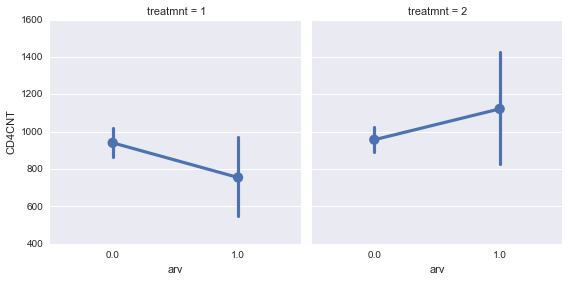

In [21]:
sns.factorplot(x='arv', y='CD4CNT', col='treatmnt', data=df)

In [22]:
years_since = df.groupby(level='newpid').VDATE.apply(lambda x: (x - x.min()).dt.days / 365)
df['age'] = df.baseage + years_since

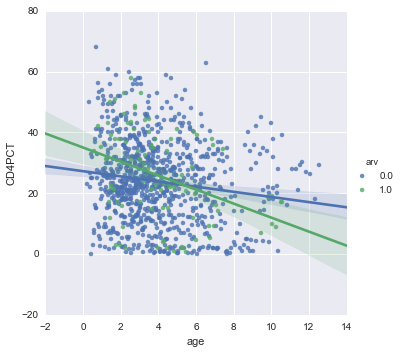

In [23]:
sns.lmplot("age", "CD4PCT", data=df, hue="arv")

These statistics are throwing away information. They don't tie one observation of an individual to the second observation *of the same individual*. We'd expect some people to consistently have higher or lower `CD4PCT` than others. We'll use a GEE model, but we have to extract the age at the time of each observation to get there.

In [24]:
mod_basic = sm.GEE.from_formula("CD4PCT ~ age + arv + treatmnt", "newpid", df.reset_index())
res_basic = mod_basic.fit()
res_basic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      CD4PCT   No. Observations:                  978
Model:                                 GEE   No. clusters:                      226
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   7
Family:                           Gaussian   Mean cluster size:                 4.3
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Thu, 23 Jul 2015   Scale:                         171.820
Covariance type:                    robust   Time:                         14:01:36
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     23.9086      2.997      7.977      0.000        18.034    29.783
age           -0.9923      0.373     -2.661      0.008        -1.723    -0.261
arv            1.6919      2.070      0.817      0.414        -2.365     5.749
treatmnt       2.7020      1.635      1.653      0.098        -0.503     5.907
==============================================================================
Skew:                          0.2773   Kurtosis:                      -0.3432
Centered skew:                 0.2924   Centered kurtosis:              3.2945
==============================================================================
"""

In [25]:
ex = sm.cov_struct.Exchangeable()
mod_exchangable = sm.GEE.from_formula("CD4PCT ~ age + arv + treatmnt", "newpid", df.reset_index(),
                                      cov_struct=ex)
res_exchangable = mod_exchangable.fit()
res_exchangable.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      CD4PCT   No. Observations:                  978
Model:                                 GEE   No. clusters:                      226
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   7
Family:                           Gaussian   Mean cluster size:                 4.3
Dependence structure:         Exchangeable   Num. iterations:                    10
Date:                     Thu, 23 Jul 2015   Scale:                         175.419
Covariance type:                    robust   Time:                         14:01:38
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     27.4284      2.801      9.792      0.000        21.939    32.918
age           -1.7609      0.336     -5.244      0.000        -2.419    -1.103
arv            1.9451      1.181      1.647      0.100        -0.369     4.260
treatmnt       1.9567      1.569      1.247      0.212        -1.119     5.032
==============================================================================
Skew:                          0.2521   Kurtosis:                      -0.3788
Centered skew:                 0.2914   Centered kurtosis:              3.3861
==============================================================================
"""

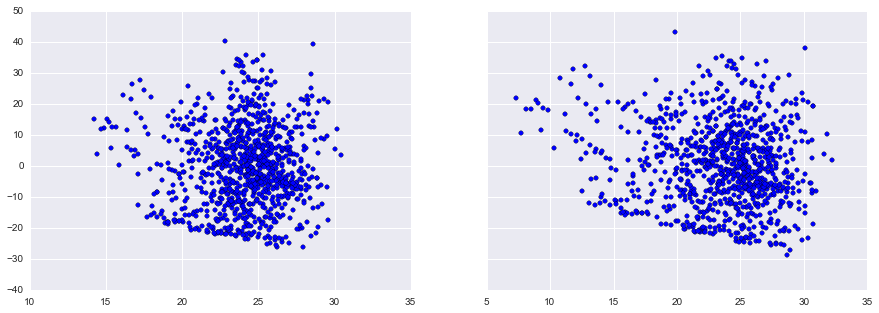

In [26]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2, sharey=True)
axes[0].scatter(res_basic.fittedvalues, res_basic.resid)
axes[1].scatter(res_exchangable.fittedvalues, res_exchangable.resid)

# Scikit-Learn

Scikit-Learn's algorithms all deal with numpy arrays. My workflow is typically

- data munging in pandas
- pass numpy array to an Estimator
- wrap result in a DataFrame or Series

In [27]:
from sklearn.datasets import california_housing
data = california_housing.fetch_california_housing()

In [28]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

In [29]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41,6.984127,1.023810,322,2.555556,37.88,-122.23
1,8.3014,21,6.238137,0.971880,2401,2.109842,37.86,-122.22
2,7.2574,52,8.288136,1.073446,496,2.802260,37.85,-122.24
3,5.6431,52,5.817352,1.073059,558,2.547945,37.85,-122.25
4,3.8462,52,6.281853,1.081081,565,2.181467,37.85,-122.25


In [30]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
dtype: float64

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [32]:
%%time
param_grid = dict(
    max_features=np.arange(2, 8),
    max_depth=[2, 4],
    min_samples_split=[5, 10, 15, 20],
)
rfc = RandomForestRegressor(n_estimators=10)
gs = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
gs.fit(X.values, y.values)

CPU times: user 1.76 s, sys: 152 ms, total: 1.91 s
Wall time: 18 s


In [33]:
scores = gs.grid_scores_
scores[:10]

[mean: 0.30444, std: 0.04210, params: {'max_features': 2, 'min_samples_split': 5, 'max_depth': 2},
 mean: 0.23836, std: 0.06680, params: {'max_features': 2, 'min_samples_split': 10, 'max_depth': 2},
 mean: 0.22371, std: 0.05632, params: {'max_features': 2, 'min_samples_split': 15, 'max_depth': 2},
 mean: 0.29494, std: 0.09932, params: {'max_features': 2, 'min_samples_split': 20, 'max_depth': 2},
 mean: 0.33448, std: 0.07986, params: {'max_features': 3, 'min_samples_split': 5, 'max_depth': 2},
 mean: 0.31830, std: 0.05949, params: {'max_features': 3, 'min_samples_split': 10, 'max_depth': 2},
 mean: 0.29274, std: 0.07056, params: {'max_features': 3, 'min_samples_split': 15, 'max_depth': 2},
 mean: 0.28704, std: 0.10248, params: {'max_features': 3, 'min_samples_split': 20, 'max_depth': 2},
 mean: 0.35378, std: 0.07959, params: {'max_features': 4, 'min_samples_split': 5, 'max_depth': 2},
 mean: 0.36234, std: 0.08106, params: {'max_features': 4, 'min_samples_split': 10, 'max_depth': 2}]

In [34]:
def unpack_grid_scores(scores):
    rows = []
    params = sorted(scores[0].parameters)
    for row in scores:
        mean = row.mean_validation_score
        std = row.cv_validation_scores.std()
        rows.append([mean, std] + [row.parameters[k] for k in params])
    return pd.DataFrame(rows, columns=['mean_', 'std_'] + params)

In [35]:
scores = unpack_grid_scores(gs.grid_scores_)
scores.head()

,mean_,std_,max_depth,max_features,min_samples_split
0,0.304441,0.042104,2,2,5
1,0.238355,0.066803,2,2,10
2,0.223713,0.056323,2,2,15
3,0.294940,0.099322,2,2,20
4,0.334480,0.079860,2,3,5


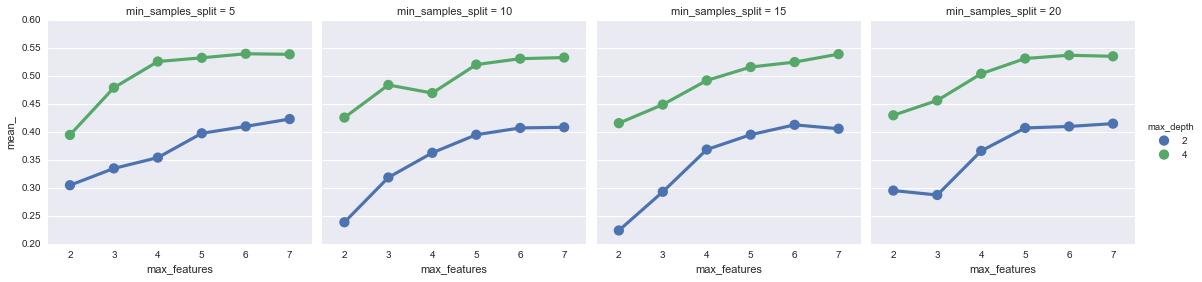

In [36]:
sns.factorplot(x='max_features', y='mean_', hue='max_depth', col='min_samples_split', data=scores)

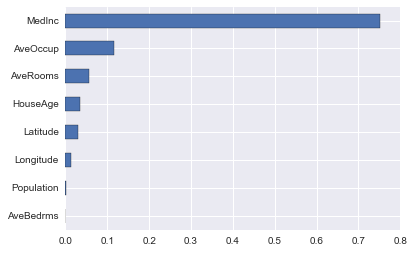

In [37]:
pd.Series(gs.best_estimator_.feature_importances_,
          index=X.columns).order().plot(kind='barh')